<div class='alert alert-success'>
    <h1 align="center"> Anomaly Detection</h1> 
    <h1 align="center"> Amir Ziaee</h1> 
</div>

## Introduction

* Anomaly detection
* Probabilistic modeling using:
 * $n$ independent uni-variate normal distribution
 * one multi-variate normal distribution
* Selecting features for anomaly detection
* Cross validation to find best value for threshold $\epsilon$
* Evaluation using precision, recall and F1-score.

In [54]:
%matplotlib nbagg

import warnings
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import ipywidgets as widgets #'7.3.0'
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import pinv
from scipy.stats import multivariate_normal

import seaborn as sns; sns.set()

In [55]:
plt.rcParams['figure.figsize'] = (4, 4)
np.set_printoptions(precision=2)
warnings.filterwarnings('ignore')

## Visualize Data

Dataset:
* 307 observations
* each observation contains **latency** and **throughput**.

In [56]:
def read_dataset(fname, delimiter=','):
    return np.genfromtxt(fname, delimiter=delimiter)

X = read_dataset('data/tr_server_data.csv')
print(X.shape)
print(X[:5])

(307, 2)
[[13.05 14.74]
 [13.41 13.76]
 [14.2  15.85]
 [14.91 16.17]
 [13.58 14.04]]


<IPython.core.display.Javascript object>


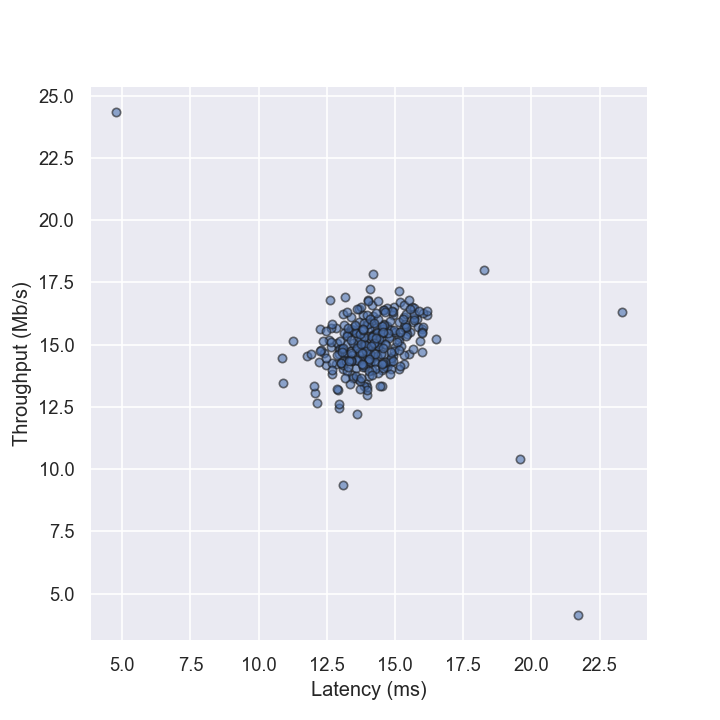

In [57]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=25, edgecolors='k', cmap='coolwarm', alpha=0.6)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (Mb/s)')
plt.show()

### Anomaly detection

First of all we need to know Gaussian (Normal) Distribution (is a preliminary subject for statistics and probabilistic machine learning). Gaussian points distribution symmetric around the mean value and spread with respect to the variance so it has two parameters as mean μ and variance sigma^2,. These two parameters are enough to define a gaussian.


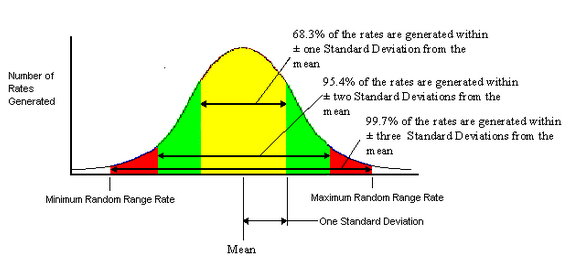

<IPython.core.display.Javascript object>


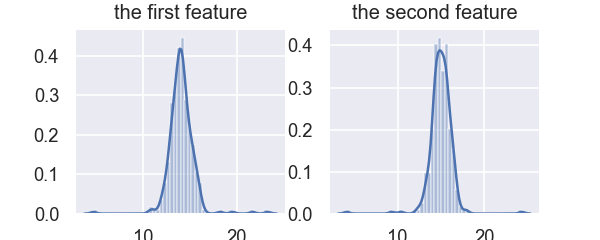

In [58]:
plt.figure(figsize=(5, 2))
plt.subplot(121)
plt.title('the first feature')


sns.distplot(X[:, 0])
plt.subplot(122)
sns.distplot(X[:, 1])
plt.title('the second feature')
plt.show()

It is possible to have attributes not in Gaussian Distribution there are couple of ways to converge them to Gaussian that mentioned at the end of this moudule .



Here, we model our data using a bi-variate normal distribution. To do this, we need to estimate the following parameters of the normal distribution:
* $\mu$: mean of the normal distribution
* $\Sigma$: Covariance matrix of the normal distribution

In python, this is a very simple task. We can use the `mean()` and `cov()` functions from `numpy`.

In [59]:
X.T.shape #each row is a feature for the covariance matrix

(2, 307)

In [60]:
mu = np.mean(X, axis=0)
Sigma = np.cov(X.T) # the shape of the covariance matrix should be n*n which n is feattures

print('mu =\n {}'.format(mu))
print('Sigma =\n {}'.format(Sigma))

mu =
 [14.11 15.  ]
Sigma =
 [[ 1.84 -0.23]
 [-0.23  1.72]]


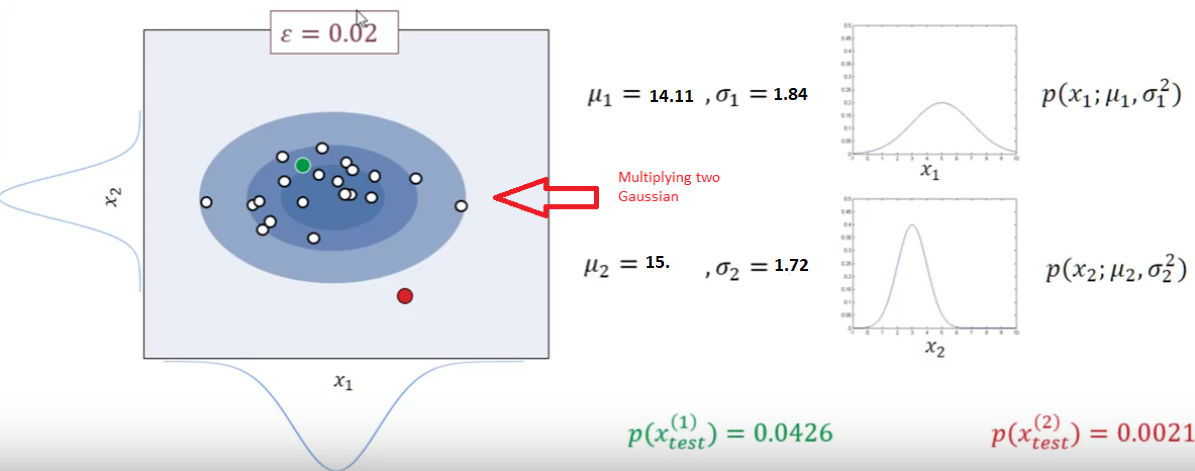

Spread of the first feature is 1.84

Spread of the second feature is 1.72

Covariance Matrix

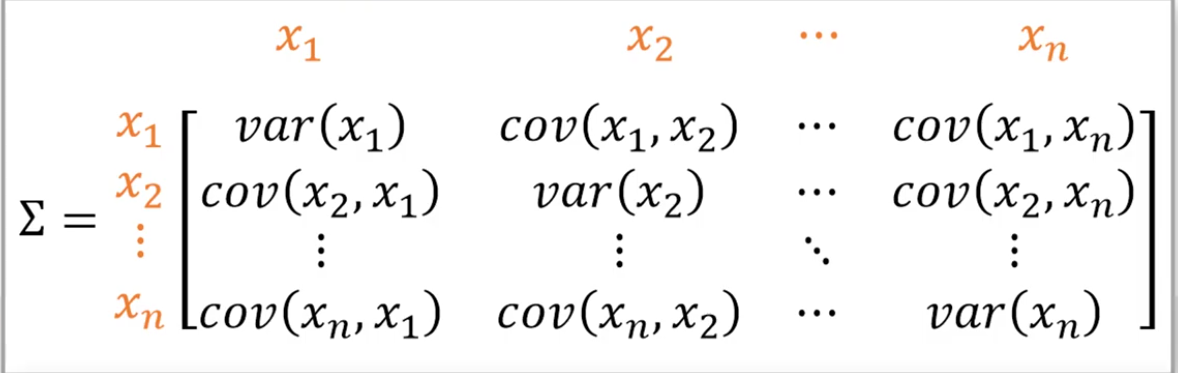
How to calculate covariance

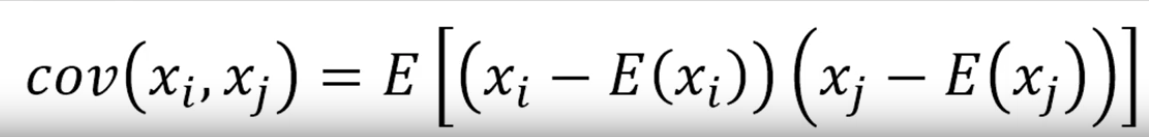

we can set the entire value of the covariance matrix to zero, except diameter, to avoid any correlation between the variables.
notice: To anomlay detection,we should take to account the correlation obetween variables

** Sigma = [[ 1.84, 0], [0 ,1.72]] **


Now that we have estimated the required parameters of the normal distribution for each feature (mean vector and covariance matrix), we can easily build our probabilistic model. 

After defining the probabilistic model $p(x)$, we can compute the probability of observing a data sample $x$ or a set of samples $X$.

In [61]:
# defining the probabilistic model and computing 
# the probabilty of observing each data in training data
p = multivariate_normal(mean=mu, cov=Sigma).pdf(X)

# print the probabilities for the first 10 data
print(p.shape)
print(p[:10])

(307,)
[0.06 0.05 0.07 0.05 0.06 0.04 0.04 0.03 0.02 0.05]


Now that we can compute the probability of each observation, it is enough to compare this probability with a threshod $\epsilon$. for each observation $x$:
* if $p(x) < \epsilon$, then $x$ can be detected as an **anomalous data**.
* if $p(x) \ge \epsilon$, then $x$ can be regarded as a **normal data**.




For now you can try different values for $\epsilon$ interactively. But later, you will see how you can choose a proper value for this hyper-parameter using vaidation data and F1-score.

<IPython.core.display.Javascript object>


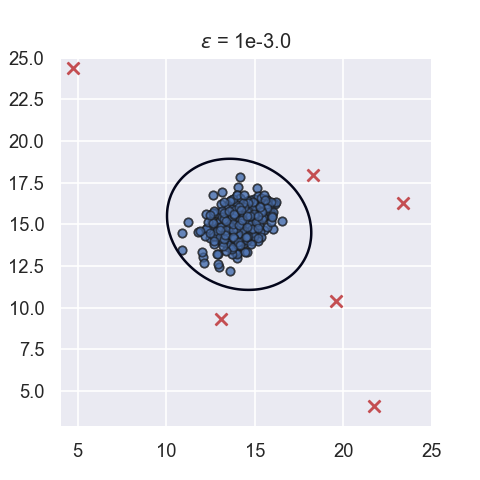

interactive(children=(FloatLogSlider(value=0.001, description='eps', max=-1.0, min=-10.0, step=1.0), Output())…

In [62]:

import ipywidgets as widgets



x1 = np.linspace(4, 25, 200)
x2 = np.linspace(4, 25, 200)
X1, X2 = np.meshgrid(x1, x2)


fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

def update_epsilon(eps):
    ax.clear()
    
    # plot normal and anomalous data
    p = multivariate_normal(mean=mu, cov=Sigma).pdf(X)
    normal = X[p >= eps]
    outlier = X[p < eps]
    ax.scatter(normal[:, 0], normal[:, 1], s=25, marker='o', c='b', edgecolors='k', cmap='coolwarm', alpha=0.6)
    ax.scatter(outlier[:, 0], outlier[:, 1], s=50, marker='x', c='r', edgecolors='k', cmap='coolwarm')
    
    # plot contour related to epsilon
    p = multivariate_normal(mean=mu, cov=Sigma).pdf(np.c_[X1.ravel(), X2.ravel()])
    p = p.reshape(X1.shape)
    ax.contour(X1, X2, p, levels=[eps])
    
    ax.scatter(normal[:, 0], normal[:, 1], s=25, marker='o', c='b', edgecolors='k', cmap='coolwarm', alpha=0.6)
    ax.scatter(outlier[:, 0], outlier[:, 1], s=50, marker='x', c='r', edgecolors='k', cmap='coolwarm')
    ax.set_title("$\epsilon$ = 1e{}".format(np.log10(eps)))
    plt.show()
    
eps = widgets.FloatLogSlider(value=1e-3, base=10, min=-10, max=-1, step=1, desc='epsilon')

widgets.interact(update_epsilon, eps=eps);

<IPython.core.display.Javascript object>


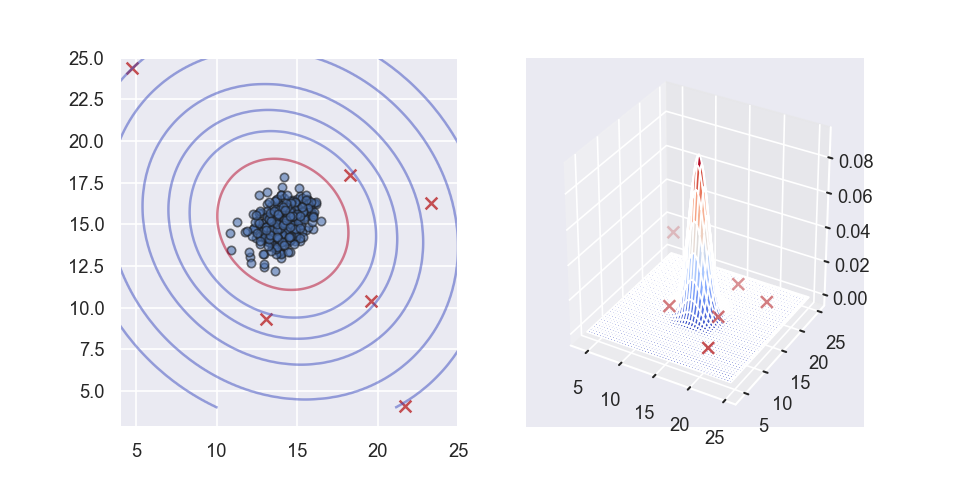

In [63]:
x1 = np.linspace(4, 25, 200)
x2 = np.linspace(4, 25, 200)
X1, X2 = np.meshgrid(x1, x2)

p = multivariate_normal(mean=mu, cov=Sigma).pdf(X)
normal = X[p >= 0.001]
outlier = X[p < 0.001]

p = multivariate_normal(mean=mu, cov=Sigma).pdf(np.c_[X1.ravel(), X2.ravel()])
p = p.reshape(X1.shape)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

levels = [1e-20, 1e-15, 1e-10, 1e-7, 1e-5, 1e-3]
ax1.contour(X1, X2, p, levels, cmap='coolwarm', alpha=0.5)
ax1.scatter(normal[:, 0], normal[:, 1], s=25, marker='o', c='b', edgecolors='k', alpha=0.6, cmap='coolwarm')
ax1.scatter(outlier[:, 0], outlier[:, 1], s=50, marker='x', c='r', edgecolors='k', cmap='coolwarm')

ax2.plot_surface(X1, X2, p, cmap='coolwarm')
ax2.scatter3D(outlier[:, 0], outlier[:, 1], 0.015, s=50, marker='x', c='r')
plt.show()

### Choosing epsilon

<IPython.core.display.Javascript object>


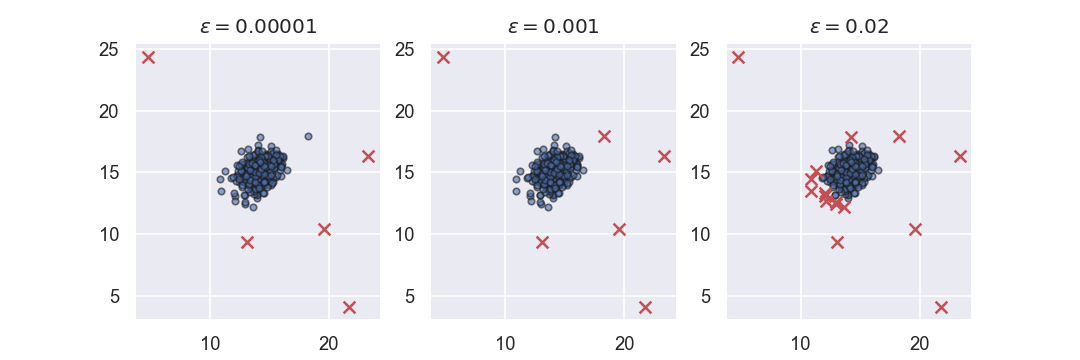

In [64]:
X = read_dataset('data/tr_server_data.csv')
p = multivariate_normal(mean=mu, cov=Sigma).pdf(X)

plt.figure(figsize=(9, 3))

plt.subplot(131)
EPSILON = 1e-5
plt.scatter(X[p >= EPSILON, 0], X[p >= EPSILON, 1], s=15,  marker='o', c='b', edgecolors='k', alpha=0.6)
plt.scatter(X[p <  EPSILON, 0], X[p <  EPSILON, 1], s=50, marker='x', c='r', edgecolors='k')
plt.title('$\epsilon=0.00001$')
plt.show()

plt.subplot(132)
EPSILON = 1e-3
plt.scatter(X[p >= EPSILON, 0], X[p >= EPSILON, 1], s=15,  marker='o', c='b', edgecolors='k', alpha=0.6)
plt.scatter(X[p <  EPSILON, 0], X[p <  EPSILON, 1], s=50, marker='x', c='r', edgecolors='k')
plt.title('$\epsilon=0.001$')

plt.subplot(133)
EPSILON = 1e-2
plt.scatter(X[p >= EPSILON, 0], X[p >= EPSILON, 1], s=15,  marker='o', c='b', edgecolors='k', alpha=0.6)
plt.scatter(X[p <  EPSILON, 0], X[p <  EPSILON, 1], s=50, marker='x', c='r', edgecolors='k')
plt.title('$\epsilon=0.02$')

plt.show()

To choose a proper value for this hyper-parameter(epsilon) we can use a vaidation dataset and F1-score(Evaluation Metrics).



assume, the number of the whole sample of a datase is 10,000(9,960,000 with 40 labeled samples)and will be splitted into
        
       * Training Set=6,000 without any labeled samples 
        
       * Validation Set=2,000 (1980 samples and 20 labeled samples (1 as anormaly ))
        
       * Test Set=2,000  (1980 samples and 20 labeled samples(1 as anormaly ))
        

evaluation Metrics for anomaly detection:
         
       * Precision: The denominator of the Precision means the sum of the whole predeictions that are predictited as positive 1 (right TP or wrong TN)and the question is: from the whole positive  prediction (right and wrong) which percentage is the right positive. in other word : what percentage of the total positive prediction is really positive. 
         
       * Recall refers to the percentage of total relevant results correctly classified by your algorithm(which percentage of all positive data(Ground Truth) is detected? in our case : how many precent of the labeled samples is identified?). 
        
        
        
  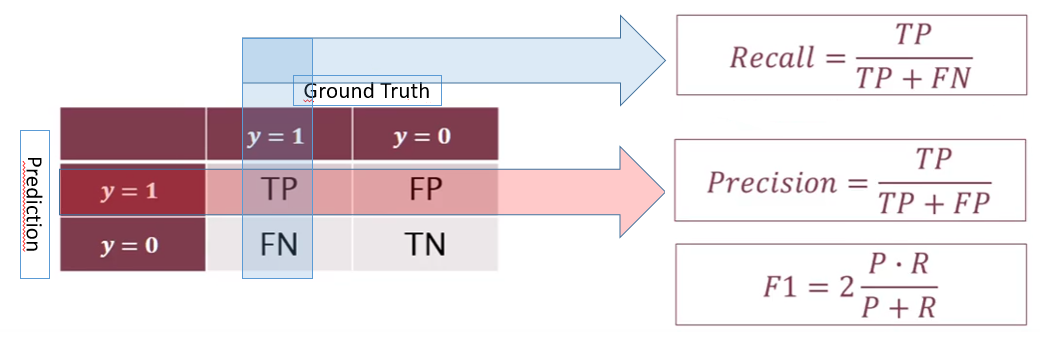
        
        
        



Load validation data

In [65]:
X_val = read_dataset('data/cv_server_data.csv')  # validation dataset
y_val = read_dataset('data/gt_server_data.csv')  # ground truth for validation dataset

print(X_val.shape, y_val.shape)
print(y_val[:10])

(307, 2) (307,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [66]:
def select_epsilon(y_val, p_val):
    best_epsilon = 0
    best_f1 = 0
    
    min_p, max_p = p_val.min(), p_val.max()
    step_size = (max_p - min_p) / 1000.0

    for epsilon in np.arange(min_p, max_p + step_size, step_size):
        
        # PREDICT OUTLIERS
        y_pred = (p_val < epsilon)
        
        # calculate TP, FP and FN
        tp = np.sum((y_pred == 1) & (y_val == 1)) * 1.0
        fp = np.sum((y_pred == 1) & (y_val == 0)) * 1.0
        fn = np.sum((y_pred == 0) & (y_val == 1)) * 1.0
                
        # calculate Precision, Recall and F1-score
        precision = tp / (tp + fp)
        recall    = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
                
        if f1 > best_f1:
            best_f1, best_epsilon = f1, epsilon

    return best_f1, best_epsilon

Choose a value for $\epsilon$ which has maximum f1-score on validation data.

In [67]:
# STEP 1: estimate parameters mu and sigma from X_val
mu_val = np.mean(X_val, axis=0)
Sigma_val = np.cov(X_val.T)

# STEP 2: calculate probabilities
p_val = multivariate_normal(mean=mu_val, cov=Sigma_val).pdf(X_val)

# STEP 3: choose best value for epsilon
f1, eps = select_epsilon(y_val, p_val)
print("f1 = {:.2g}, epsilon = {}".format(f1, eps))

f1 = 0.88, epsilon = 8.701942787318034e-05


<IPython.core.display.Javascript object>


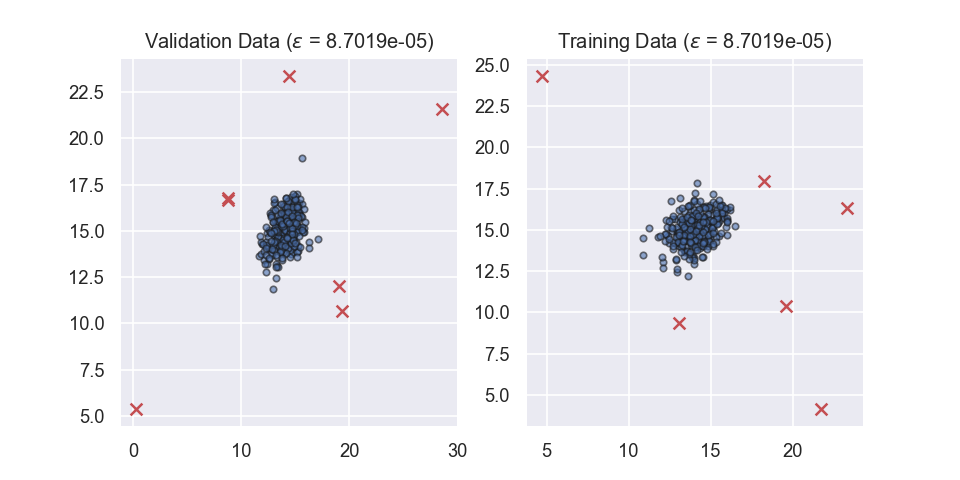

In [68]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.scatter(X_val[p_val >= eps, 0], X_val[p_val >= eps, 1], s=15,  marker='o', c='b', edgecolors='k', alpha=0.6)
plt.scatter(X_val[p_val <  eps, 0], X_val[p_val <  eps, 1], s=50, marker='x', c='r', edgecolors='k')
plt.title('Validation Data ($\epsilon$ = {:.5g})'.format(eps))

plt.subplot(122)
# mu = np.mean(X, axis=0)
# sigma = np.cov(X.T)
p = multivariate_normal(mean=mu, cov=Sigma).pdf(X)
plt.scatter(X[p >= eps, 0], X[p >= eps, 1], s=15, marker='o', c='b', edgecolors='k', alpha=0.6)
plt.scatter(X[p <  eps, 0], X[p <  eps, 1], s=50, marker='x', c='r', edgecolors='k')
plt.title('Training Data ($\epsilon$ = {:.5g})'.format(eps))

plt.show()

## One-Class Classification

In [69]:
from sklearn.svm import OneClassSVM

In [70]:
X = read_dataset('data/tr_server_data.csv')

clf = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)# gamma is the other way round of the sigma 
clf.fit(X)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [71]:
predictions = clf.predict(X)
normal = X[predictions == 1]
outlier = X[predictions == -1]

<IPython.core.display.Javascript object>


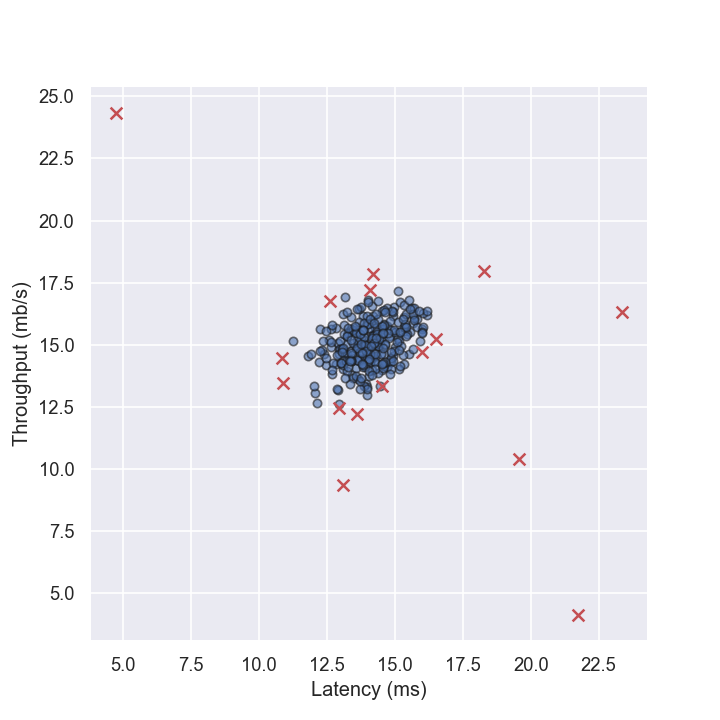

In [72]:
plt.figure(figsize=(6, 6))
plt.scatter(normal[:, 0], normal[:, 1], s=25, marker='o', c='b', edgecolors='k', alpha=0.6)
plt.scatter(outlier[:, 0], outlier[:, 1], s=50, marker='x', c='r', edgecolors='k')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

## Normal Distribution

### Single variable normal distribution

<IPython.core.display.Javascript object>


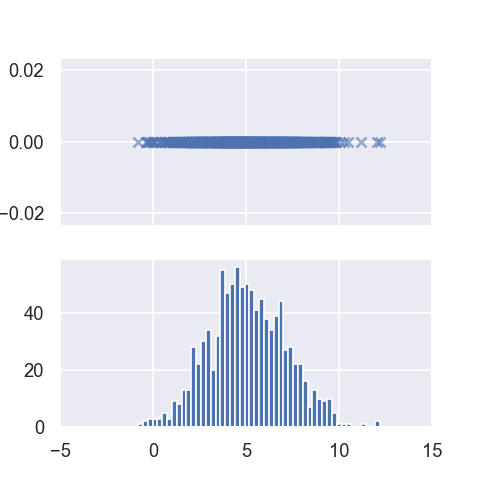

In [73]:
N = 1000
X1 = np.random.normal(5, 2, N)
f, axes = plt.subplots(nrows=2, sharex=True)
axes[0].set_xlim(-5, 15)
axes[0].scatter(X1, np.zeros(N), marker='x', alpha=0.6)
axes[1].hist(X1, bins=50)
plt.show()

In [74]:
mu = X1.mean()
sigma = X1.std()
print('Mean:', mu)
print('Standard Deviation:', sigma)

Mean: 5.083772234340509
Standard Deviation: 2.059611755461021


<IPython.core.display.Javascript object>


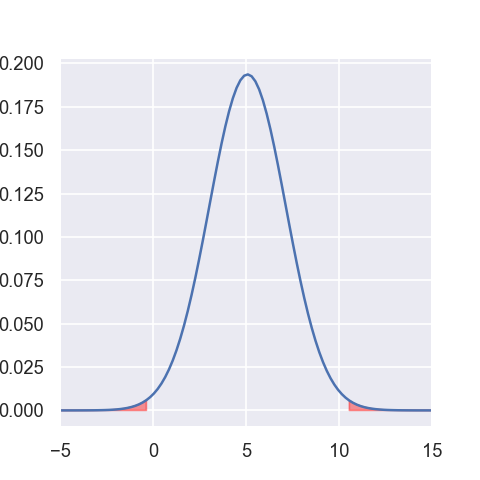

Lower Bound: -0.23002609474892566
Upper Bound: 10.397570563429944


In [75]:
base = np.linspace(-5, 15, 100)
normal = sp.stats.norm.pdf(base, mu, sigma)
lower_bound = mu - (2.58 * sigma)
upper_bound = mu + (2.58 * sigma)
anomalous = np.logical_or(base < [lower_bound]*100, base > [upper_bound]*100)

plt.figure()
plt.plot(base, normal)
plt.fill_between(base, normal, where=anomalous, color=[1, 0, 0, 0.4])
plt.xlim(-5, 15)
plt.show()
print('Lower Bound:', lower_bound)
print('Upper Bound:', upper_bound)

<IPython.core.display.Javascript object>


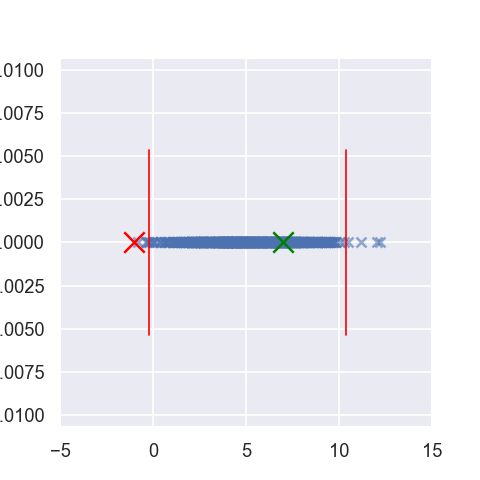

In [76]:
plt.figure()
plt.scatter(X1, np.zeros(N), marker='x', alpha=0.6)
plt.xlim(-5, 15)
plt.scatter(-1, 0, marker='x', color='red', s=150, linewidths=3)
plt.scatter(7, 0, marker='x', color='green', s=150, linewidths=3)
plt.axvline(lower_bound, ymin=.25, ymax=.75, color='red', linewidth=1)
plt.axvline(upper_bound, ymin=.25, ymax=.75, color='red', linewidth=1)
plt.show()

In [77]:
def gaussian_distribution(x, mu=0, sigma=1):
    return np.exp(-0.5 * (((x - mu) / sigma) ** 2)) / (sigma * np.sqrt(2.0 * np.pi))

Standard normal distribution ($\mu=0, \sigma^2=1$)

<IPython.core.display.Javascript object>


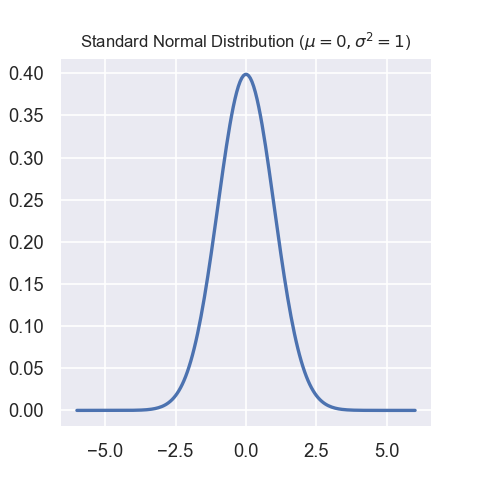

In [78]:
x = np.linspace(-6, 6, 200)
y = gaussian_distribution(x)

plt.figure()
plt.plot(x, y, lw=2)
plt.title("Standard Normal Distribution ($\mu=0, \sigma^2=1$)", size=10)
plt.show()

Normal distribution with arbitrary mean and standard deviation

<IPython.core.display.Javascript object>


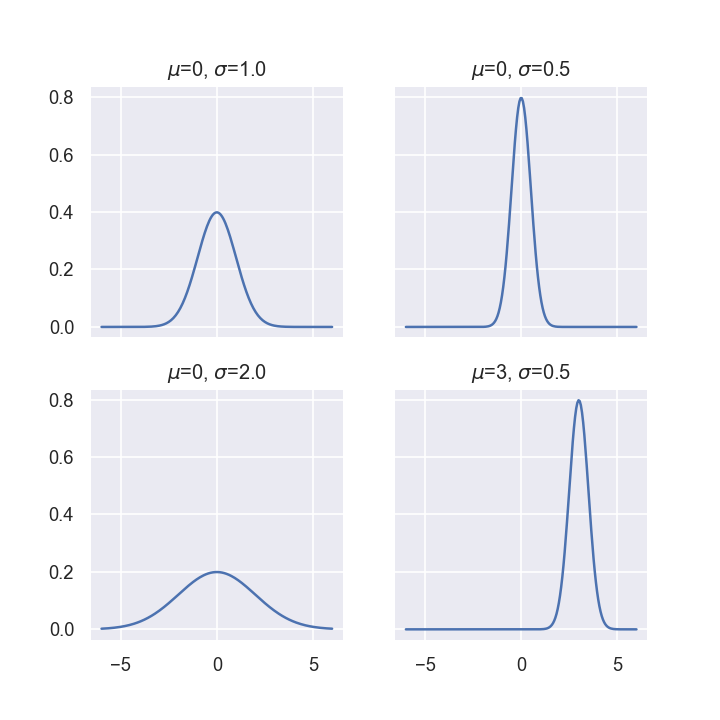

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), sharex=True, sharey=True)

y = gaussian_distribution(x, mu=0, sigma=1.0)
axes[0][0].set_title('$\mu$=0, $\sigma$=1.0')
axes[0][0].plot(x, y)

y = gaussian_distribution(x, mu=0, sigma=0.5)
axes[0][1].set_title('$\mu$=0, $\sigma$=0.5')
axes[0][1].plot(x, y)

y = gaussian_distribution(x, mu=0, sigma=2)
axes[1][0].set_title('$\mu$=0, $\sigma$=2.0')
axes[1][0].plot(x, y)

y = gaussian_distribution(x, mu=3, sigma=0.5)
axes[1][1].set_title('$\mu$=3, $\sigma$=0.5')
axes[1][1].plot(x, y)
plt.show()

<IPython.core.display.Javascript object>


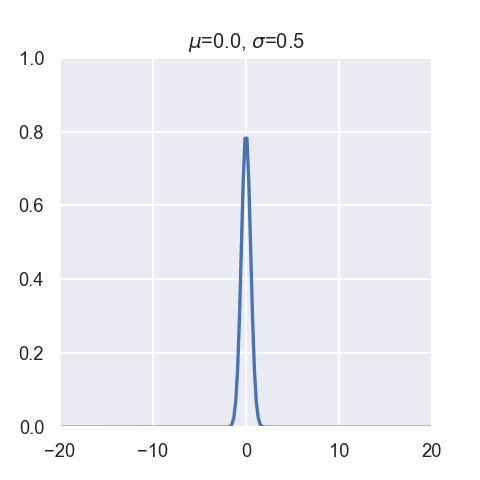

interactive(children=(FloatSlider(value=0.0, description='mu', max=5.0, min=-5.0, step=0.5), FloatSlider(value…

In [80]:
fig, ax = plt.subplots(1, figsize=(4, 4))


def update_normal_plot(mu, sigma):
    ax.clear()
    
    x = np.linspace(-20, 20, 200)
    y = gaussian_distribution(x, mu=mu, sigma=sigma)

    ax.plot(x, y, lw=2)
    ax.set_title("$\mu$={}, $\sigma$={}".format(mu, sigma))
    ax.set_xlim(-20, 20)
    ax.set_ylim(0, 1)
    plt.show()
    
mu = widgets.FloatSlider(value=0, min=-5, max=5, step=0.5, desc='Mean')
sigma = widgets.FloatSlider(value=0.5, min=0.1, max=5, step=0.1, desc='Sigma')

widgets.interact(update_normal_plot, mu=mu, sigma=sigma);

### Bi-variavte normal distribution

#### Case 1: Matrix $\Sigma$ (covariance) is diagonal

<IPython.core.display.Javascript object>


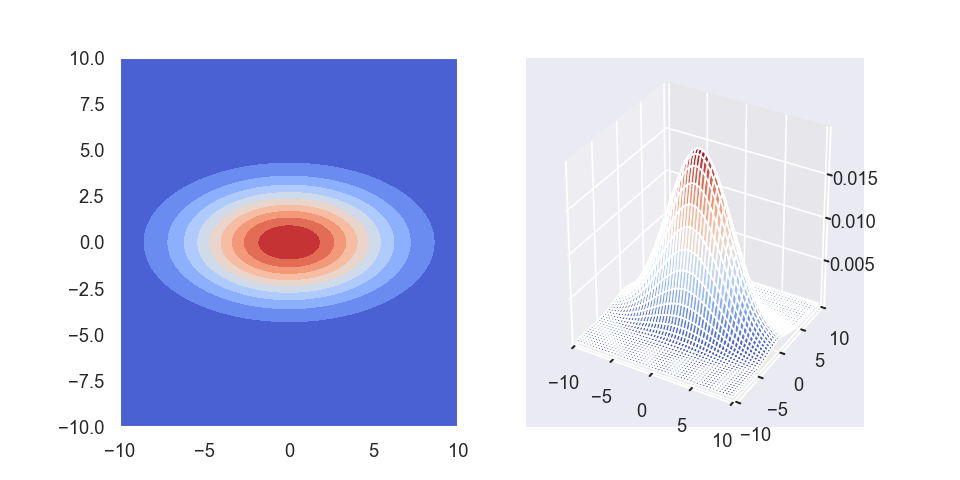

interactive(children=(FloatSlider(value=0.0, description='mu1', max=5.0, min=-5.0, step=0.5), FloatSlider(valu…

In [81]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

x1 = np.arange(-10, 10, 0.1)
x2 = np.arange(-10, 10, 0.1)
[X1, X2] = np.meshgrid(x1, x2)
X = np.c_[X1.ravel(), X2.ravel()]

def update_normal2d_surf_plot(mu1, sigma1, mu2, sigma2):
    ax1.clear()
    ax2.clear()
        
    mu = np.array([mu1, mu2])
    cov = np.array([[sigma1**2, 0], [0, sigma2**2]])
    p = sp.stats.multivariate_normal(mean=mu, cov=cov).pdf(X)
    p = p.reshape(X1.shape)

    ax1.contourf(X1, X2, p, levels=10, cmap='coolwarm')
#     ax1.set_title("$\mu$={}, $\sigma$={}".format(mu, np.diag(cov)), size=12)
    ax1.set_xlim(-10, 10)
    ax1.set_ylim(-10, 10)
    
#     ax2.set_title("$\mu$={}, $\sigma$={}".format(mu, np.diag(cov)))
    ax2.plot_surface(X1, X2, p, cmap='coolwarm')
    ax2.set_xlim(-10, 10)
    ax2.set_ylim(-10, 10)
    plt.show()
    
mu1 = widgets.FloatSlider(value=0, min=-5, max=5, step=0.5, desc='Mean')
sigma1 = widgets.FloatSlider(value=4.0, min=0.0, max=5, step=0.5, desc='Sigma')
mu2 = widgets.FloatSlider(value=0, mmu1in=-5, max=5, step=0.5, desc='Mean')
sigma2 = widgets.FloatSlider(value=2.0, min=0.0, max=5, step=0.5, desc='Sigma')

widgets.interact(update_normal2d_surf_plot, mu1=mu1, sigma1=sigma1, mu2=mu2, sigma2=sigma2);

#### Case 2: Matrix $\Sigma$ (covariance) is not diagonal

<IPython.core.display.Javascript object>


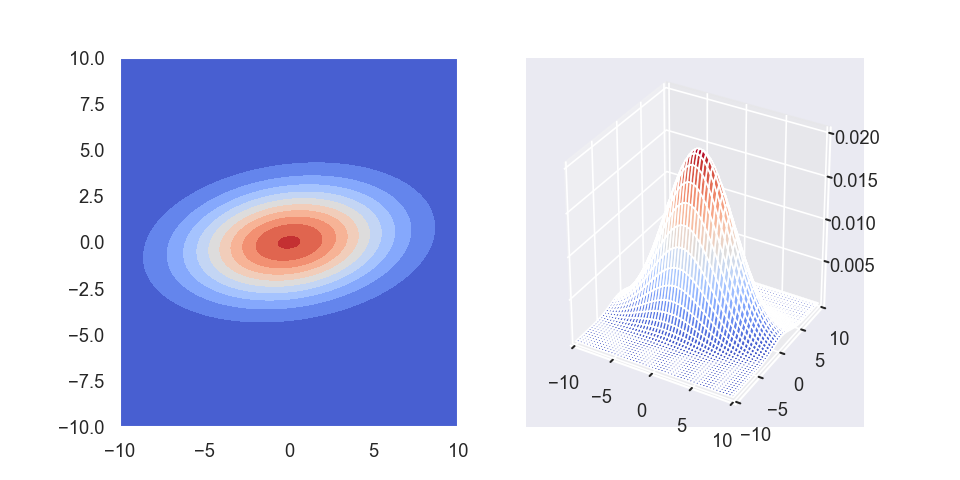

interactive(children=(FloatSlider(value=0.0, description='mu1', max=5.0, min=-5.0, step=0.5), FloatSlider(valu…

In [82]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

x1 = np.arange(-10, 10, 0.1)
x2 = np.arange(-10, 10, 0.1)
[X1, X2] = np.meshgrid(x1, x2)
X = np.c_[X1.ravel(), X2.ravel()]

def update_normal2d_cov_surf_plot(mu1, sigma1, mu2, sigma2, cov):
    ax1.clear()
    ax2.clear()
        
    mu = np.array([mu1, mu2])
    cov = np.array([[sigma1**2, cov], [cov, sigma2**2]])
    p = sp.stats.multivariate_normal(mean=mu, cov=cov).pdf(X)
    p = p.reshape(X1.shape)

    ax1.contourf(X1, X2, p, levels=10, cmap='coolwarm')
    ax1.set_xlim(-10, 10)
    ax1.set_ylim(-10, 10)
    
    ax2.plot_surface(X1, X2, p, cmap='coolwarm')
    ax2.set_xlim(-10, 10)
    ax2.set_ylim(-10, 10)
    plt.show()
    
mu1 = widgets.FloatSlider(value=0, min=-5, max=5, step=0.5, desc='Mean')
sigma1 = widgets.FloatSlider(value=4.0, min=0.0, max=5, step=0.5, desc='Sigma')
mu2 = widgets.FloatSlider(value=0, min=-5, max=5, step=0.5, desc='Mean')
sigma2 = widgets.FloatSlider(value=2.0, min=0.0, max=5, step=0.5, desc='Sigma')
cov = widgets.FloatSlider(value=1.5, min=-5, max=5, step=0.5, desc='Sigma')

widgets.interact(update_normal2d_cov_surf_plot, mu1=mu1, sigma1=sigma1, mu2=mu2, sigma2=sigma2, cov=cov);

#### Non-normally distributed single variable

It is possible to have attributes not in Gaussian Distribution there are couple of ways to converge them to Gaussian like:


    Take log() of all the values of attribute ---- X ---> log(X)
    Take root of the all attribute values ---- X ---> X^(-1/2)

<IPython.core.display.Javascript object>


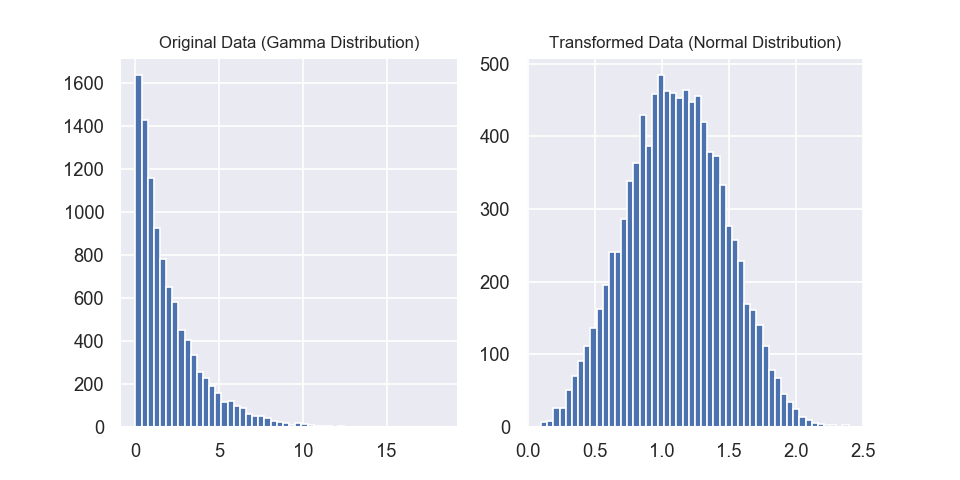

In [83]:
X1 = np.random.gamma(1, 2, size=(10000, 1))

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.hist(X1, bins=50)
plt.title('Original Data (Gamma Distribution)', size=10)

plt.subplot(122)
plt.hist(X1 ** 0.3, bins=50)
plt.title('Transformed Data (Normal Distribution)', size=10)

plt.show()

#### Multiple Independently Distributed Normal Variables

<IPython.core.display.Javascript object>


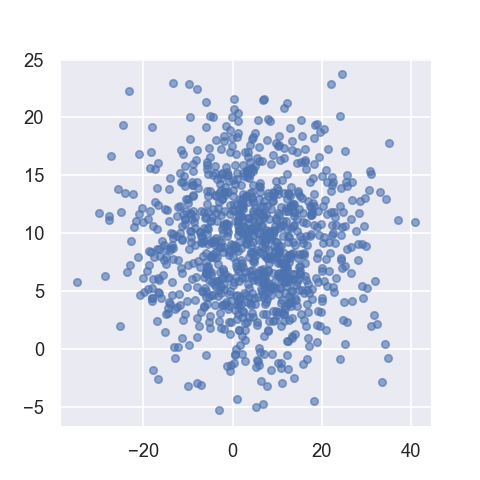

In [84]:
N = 1000
X1 = np.random.normal(4, 12, N)
X2 = np.random.normal(9, 5, N)

plt.figure()
plt.scatter(X1, X2, s=20, alpha=0.6)
plt.show()

In [85]:
mu1 = X1.mean()
mu2 = X2.mean()
sigma1 = X1.std()
sigma2 = X2.std()

print('x1 (mu = {:4.2f}, sigma = {:5.2f})'.format(mu1, sigma1))
print('x2 (mu = {:4.2f}, sigma = {:5.2f})'.format(mu2, sigma2))

x1 (mu = 3.96, sigma = 12.04)
x2 (mu = 9.07, sigma =  5.15)


<IPython.core.display.Javascript object>


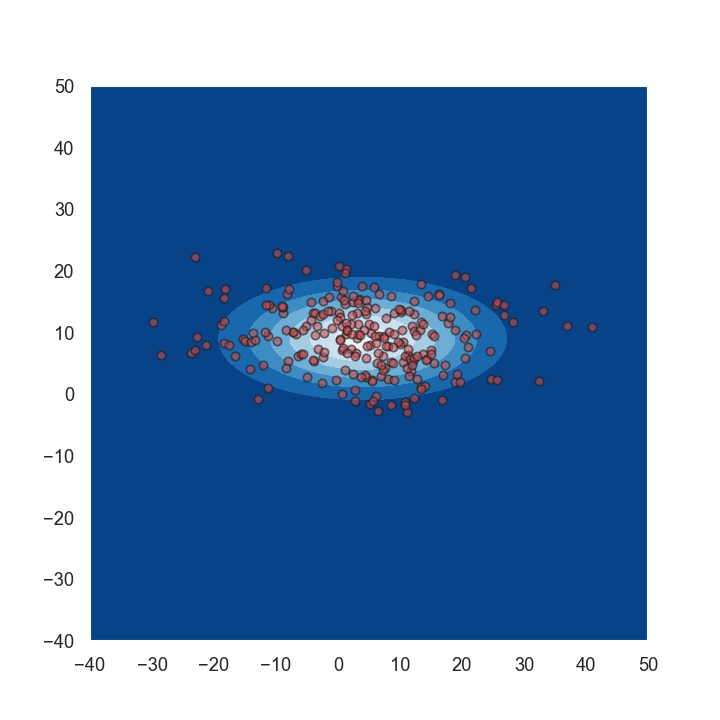

In [86]:
delta = 0.025
x1 = np.arange(-40, 50, delta)
x2 = np.arange(-40, 50, delta)
x, y = np.meshgrid(x1, x2)
z = plt.mlab.bivariate_normal(x, y, sigma1, sigma2, mu1, mu2)

plt.figure(figsize=(6, 6))
plt.contourf(x, y, z, cmap='Blues_r')
thinned_points = np.array([n in np.random.choice(N, 300) for n in range(N)])
plt.scatter(X1[thinned_points], X2[thinned_points], s=25, c='r', edgecolors='k', alpha=0.6)
plt.show()

#### Multiple Jointly Distributed Features

<IPython.core.display.Javascript object>


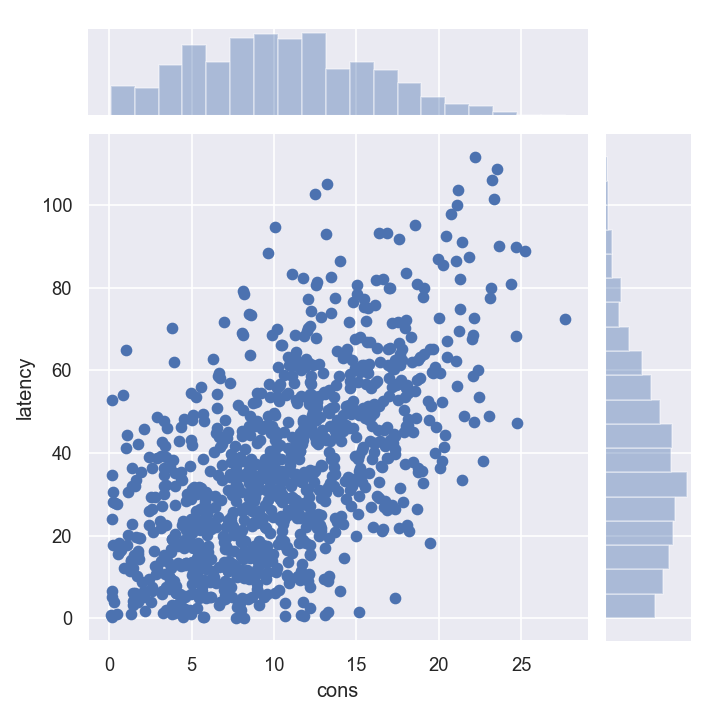

In [87]:
def positive_support_normal(mean, sigma, n):
    xs = np.random.normal(mean, sigma, n)
    for i, num in enumerate(xs):
        while num < 0:
            num = np.random.normal(mean[i], sigma)
        xs[i] = num
    return xs
    
N = 1000

mu_cons = 10
sigma_cons = 6
sigma_latency = 20
beta = 3

cons = positive_support_normal(np.array([mu_cons]*N), sigma_cons, N)
latency = positive_support_normal(beta * cons, sigma_latency, N)
ax = sns.jointplot('cons', 'latency', pd.DataFrame({'cons': cons, 'latency': latency}))

<IPython.core.display.Javascript object>


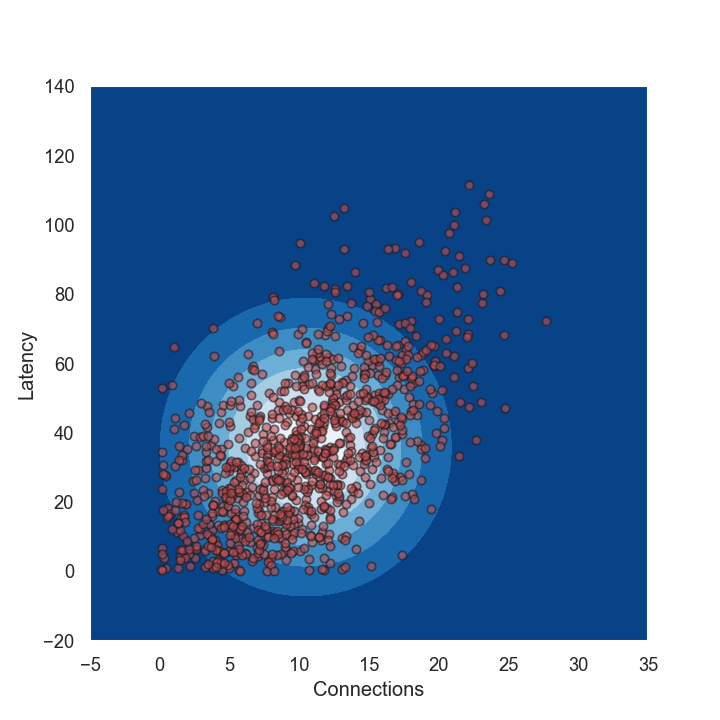

In [88]:
delta = 0.025
x1 = np.arange(-5, 35, delta)
x2 = np.arange(-20, 140, delta)
x, y = np.meshgrid(x1, x2)
z = plt.mlab.bivariate_normal(x, y, cons.std(), latency.std(), cons.mean(), latency.mean())

plt.figure(figsize=(6, 6))
plt.contourf(x, y, z, cmap='Blues_r')
plt.scatter(cons, latency, s=25, c='r', edgecolors='k', alpha=0.6)
plt.ylabel('Latency')
plt.xlabel('Connections')
plt.show()

Resource:

http://www.snrazavi.ir/ml-2018/

http://www.erogol.com/anomaly-detection-and-a-simple-algorithm-with-probabilistic-approach/


https://towardsdatascience.com/precision-vs-recall-386cf9f89488

https://github.com/A2Amir
    